In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

from pprint import pprint
import sys
from colorama import Style, Fore

rc = {
    "axes.facecolor": "#F6F6F6",
    "figure.facecolor": "#F6F6F6",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

plt.rc('axes', unicode_minus=False)

sns.set(rc=rc)


red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL


In [5]:
train = pd.read_csv('train.csv').drop('Id',axis=  1)
test = pd.read_csv('test.csv').drop('Id',axis = 1)
sub = pd.read_csv('sample_submission.csv')

In [6]:
df = train.copy()

df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1.000000,63y,4,0.544965,3902.0,6,1,2,1,0.0
1,0,0.007645,53y,0,4519.000000,0.0,13,0,2,0,0.0
2,0,0.863713,30y,0,1.337353,3316.0,14,0,2,0,0.0
3,0,0.058220,41y,0,0.289363,8065.0,9,0,1,0,2.0
4,0,0.015711,50y,0,2784.000000,NaN,16,0,2,0,0.0


In [7]:
# str - > int 
# age : 63y --> 63 :)

df['age'] = df['age'].map(lambda x: x[:-1]).astype(int)

In [8]:
def summarize(data):
    
    size = round(sys.getsizeof(data) / 1024 ** 2,2)
    print(f'Data size : {size}MB')
    
    result = pd.DataFrame()
    
    result['Dtypes'] = data.dtypes.values
    result['Count'] = data.count().values
    result['Nunique'] = data.nunique().values
    result['Missing value'] = data.isna().sum().values
    result['Most Freq Value'] = data.mode().iloc[0].values
    result['Min'] = data.describe(include = 'all').T['min'].values
    result['Max'] = data.describe(include = 'all').T['max'].values
    result['Mean'] = data.describe(include = 'all').T['mean'].values
    result['Median'] = data.describe(include = 'all').T['50%'].values
    
    result = result.set_index(data.columns)
    return result

In [9]:
summarize(df)

Data size : 5.88MB


,Dtypes,Count,Nunique,Missing value,Most Freq Value,Min,Max,Mean,Median
SeriousDlqin2yrs,int64,73363,2,0,0.0,0.0,1.0,0.066191,0.000000
RevolvingUtilizationOfUnsecuredLines,float64,73363,62269,0,0.0,0.0,29110.0,5.770756,0.153077
age,int32,73363,83,0,49.0,0.0,109.0,52.355152,52.000000
NumberOfTime30-59DaysPastDueNotWorse,int64,73363,13,0,0.0,0.0,98.0,0.413151,0.000000
DebtRatio,float64,73363,59254,0,0.0,0.0,329664.0,353.626057,0.366197
MonthlyIncome,float64,58839,10593,14524,5000.0,0.0,1794060.0,6647.915549,5400.000000
NumberOfOpenCreditLinesAndLoans,int64,73363,54,0,6.0,0.0,54.0,8.456347,8.000000
NumberOfTimes90DaysLate,int64,73363,19,0,0.0,0.0,98.0,0.256587,0.000000
NumberRealEstateLoansOrLines,int64,73363,24,0,0.0,0.0,32.0,1.017338,1.000000
NumberOfTime60-89DaysPastDueNotWorse,int64,73363,11,0,0.0,0.0,98.0,0.231152,0.000000


### **It seem like binary classifier data**
### **first of all, we have to imputation the missing value**

# **Reduce Memory**

In [10]:
class ReduceMemory:
    

        
    def fit_transform(self,data):
        
        self.data = data
        
        cols = self.data.columns
        
        # 원본 data 사이즈
        raw_datasize = round(sys.getsizeof(df)/1024**2,2)
        print(f'{mgt}ReduceMemory Start{res}\n')
        print('--' * 20)
        original_lable = {}
        
        for col in cols:
            
            dtype = self.data[col].dtype
            
            if dtype == 'object':
                
                before_size = round(sys.getsizeof(self.data[col]) / 1024 ** 2,2)
                
                transformlabel = {v:k for k,v in enumerate(self.data[col].unique())}
                raw_label = {k:v for k,v in enumerate(self.data[col].unique())}
                
                self.data[col] = self.data[col].map(transformlabel).astype('int8')

                after_size = round(sys.getsizeof(self.data[col]) / 1024 ** 2,2)
            
                original_lable[col] = raw_label 

                print(f'{blu}{col}{res} {blu}{before_size}MB {gld}-> {red}{after_size}MB{res}',sep = '\t')


                
                
            elif dtype == 'float':
                
                before_size = round(sys.getsizeof(self.data[col]) / 1024 ** 2,2)
                
                min_value,max_value = self.data[col].min(), self.data[col].max()
                

                if min_value >= np.finfo('float16').min and max_value <= np.finfo('float16').max:
                    self.data[col] = self.data[col].astype('float16')
                elif min_value >= np.finfo('float32').min and max_value <= np.finfo('float32').max:
                    self.data[col] = self.data[col].astype('float32')
                else:
                    self.data[col] = self.data[col].astype('float64')
                    
                after_size = round(sys.getsizeof(self.data[col]) / 1024**2,2)
                
                print(f'{blu}{col}{res} {blu}{before_size}MB {gld}-> {red}{after_size}MB{res}',sep = '\t')

                
            else:
                
                before_size = round(sys.getsizeof(self.data[col]) / 1024 ** 2,2)
                
                min_value,max_value = self.data[col].min(), self.data[col].max()
                
                if min_value >= np.iinfo('int8').min and max_value <= np.iinfo('int8').max:
                    self.data[col] = self.data[col].astype('int8')
                if min_value >= np.iinfo('int16').min and max_value <= np.iinfo('int16').max:
                    self.data[col] = self.data[col].astype('int16')
                elif min_value >= np.iinfo('int32').min and max_value <= np.iinfo('int32').max:
                    self.data[col] = self.data[col].astype('int32')
                else:
                    self.data[col] = self.data[col].astype('int64')
                    
                after_size = round(sys.getsizeof(self.data[col]) / 1024**2,2)
                
                print(f'{blu}{col}{res} {blu}{before_size}MB {gld}-> {red}{after_size}MB{res}',sep = '\t')
                
        after_datasize = round(sys.getsizeof(self.data) / 1024**2,2)
        
        print('--' * 20)
        print(f'{mgt}Reduce Memory Done{mgt} \n')
        print(f'{blu}Original data size :{raw_datasize}MB{res}')    
        print(f'{red}After data size : {after_datasize}MB{res}')
        
        return self.data,original_lable

In [11]:
reduce_scaler = ReduceMemory()

df,original_labels = reduce_scaler.fit_transform(df)

ReduceMemory Start

----------------------------------------
SeriousDlqin2yrs 0.56MB -> 0.14MB
RevolvingUtilizationOfUnsecuredLines 0.56MB -> 0.14MB
age 0.28MB -> 0.14MB
NumberOfTime30-59DaysPastDueNotWorse 0.56MB -> 0.14MB
DebtRatio 0.56MB -> 0.28MB
MonthlyIncome 0.56MB -> 0.28MB
NumberOfOpenCreditLinesAndLoans 0.56MB -> 0.14MB
NumberOfTimes90DaysLate 0.56MB -> 0.14MB
NumberRealEstateLoansOrLines 0.56MB -> 0.14MB
NumberOfTime60-89DaysPastDueNotWorse 0.56MB -> 0.14MB
NumberOfDependents 0.56MB -> 0.14MB
----------------------------------------
Reduce Memory Done 

Original data size :5.88MB
After data size : 1.82MB


# **Missing value Imputataion**

In [12]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_absolute_error,accuracy_score

In [13]:
class LGBMimputer:
            
    def regressor_trasform(self,data,col, n = 5):
        
        print('Imputation using LGBMRegressor START')

        
        self.data = data
        self.model = LGBMRegressor(verbose = -1)
        
        params = {'learning_rate':0.1,
                                'n_estimators': 300,
                                'num_leaves':31,
                                'min_child_samples': 50,
                                'reg_alpha': 0.1,
                                'reg_lambda': 0.1}
        
        self.model.set_params(**params)

        self.train = self.data[~self.data[col].isna()]
        self.test =  self.data[self.data[col].isna()]
        
        x_train,x_test,y_train,y_test = train_test_split(self.train.drop(col,axis = 1),
                                                            self.train[col], random_state = 42)
        
        cv = KFold(n_splits = n , random_state = 42, shuffle = True)
        
        avg_score = 0
        oof_pred_list = []

        for i, (train_idx,test_idx) in enumerate(cv.split(x_train,y_train)):
            
            train_x,train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x,valid_y = x_train.iloc[test_idx], y_train.iloc[test_idx]
            
            self.model.fit(train_x,train_y)
            
            train_pred = self.model.predict(train_x)
            valid_pred = self.model.predict(valid_x)
            
            oof_pred = self.model.predict(self.test.drop(col,axis = 1))
            oof_pred_list.append(oof_pred)
            
            train_score = round(mean_absolute_error(train_y,train_pred),2)
            valid_score = round(mean_absolute_error(valid_y,valid_pred),2)
            
            print(f'{blu}{i + 1} FOLD MSE : TRAIN : {train_score} VALID : {valid_score}')
            avg_score += valid_score / n 
            
        print(f'{mgt}{n} FOLD AVG MSE : {round(avg_score,2)}{res}')

        missing_pred = np.mean(oof_pred_list,axis = 0)
        
        self.data.loc[self.data[col].isna(), col] = missing_pred
        
        print('Regressor Imputation END')
    
        return self.data         
    
    
    def classifier_trasform(self,data,col, n = 5):
        
        print('Imputation using LGBMClassifier START')
        
        self.data = data
        self.model = LGBMClassifier()
        
        params = {'learning_rate':0.1,
                                'n_estimators': 300,
                                'num_leaves':31,
                                'min_child_samples': 50,
                                'reg_alpha': 0.1,
                                'reg_lambda': 0.1}
        
        self.model.set_params(**params)

        self.train = self.data[~self.data[col].isna()]
        self.test =  self.data[self.data[col].isna()]
        
        x_train,x_test,y_train,y_test = train_test_split(self.train.drop(col,axis = 1),
                                                            self.train[col], random_state = 42)
        
        cv = KFold(n_splits = n , random_state = 42, shuffle = True)
        
        avg_score = 0
        oof_pred_list = []

        for i, (train_idx,test_idx) in enumerate(cv.split(x_train,y_train)):
            
            train_x,train_y = x_train.iloc[train_idx], y_train.iloc[train_idx]
            valid_x,valid_y = x_train.iloc[test_idx], y_train.iloc[test_idx]
            
            self.model.fit(train_x,train_y)
            
            train_pred = self.model.predict(train_x)
            valid_pred = self.model.predict(valid_x)
            
            oof_pred = self.model.predict(self.test.drop(col,axis = 1))
            oof_pred_list.append(oof_pred)
            
            train_score = round(accuracy_score(train_y,train_pred),2)
            valid_score = round(accuracy_score(valid_y,valid_pred),2)
            
            print(f'{blu}{i + 1} FOLD F1 SCORE : TRAIN : {train_score} VALID : {valid_score}')
            avg_score += valid_score / n 
            
        print(f'{mgt}{n} FOLD AVG MSE : {round(avg_score,2)}{res}')

        missing_pred = np.mean(oof_pred_list,axis = 0)
        
        self.data.loc[self.data[col].isna(), col] = missing_pred
        
        print('Classifier Transfrom END')

        return self.data         
    

In [14]:
missing_cols = ['MonthlyIncome','NumberOfDependents']

imputer = LGBMimputer()

df = imputer.regressor_trasform(df,missing_cols[0])
df = imputer.classifier_trasform(df,missing_cols[1])

Imputation using LGBMRegressor START
1 FOLD MSE : TRAIN : 2564.73 VALID : 2823.02
2 FOLD MSE : TRAIN : 2540.44 VALID : 2743.44
3 FOLD MSE : TRAIN : 2530.49 VALID : 2711.22
4 FOLD MSE : TRAIN : 2418.55 VALID : 2789.39
5 FOLD MSE : TRAIN : 2460.01 VALID : 2754.09
5 FOLD AVG MSE : 2764.23
Regressor Imputation END
Imputation using LGBMClassifier START
1 FOLD F1 SCORE : TRAIN : 0.71 VALID : 0.6
2 FOLD F1 SCORE : TRAIN : 0.71 VALID : 0.59
3 FOLD F1 SCORE : TRAIN : 0.71 VALID : 0.59
4 FOLD F1 SCORE : TRAIN : 0.71 VALID : 0.59
5 FOLD F1 SCORE : TRAIN : 0.71 VALID : 0.59
5 FOLD AVG MSE : 0.59
Classifier Transfrom END


In [15]:
df.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

# **Modeling**

In [16]:
from sklearn.decomposition import PCA

In [17]:
X,y = df.drop('SeriousDlqin2yrs',axis = 1), df['SeriousDlqin2yrs']

pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(X))
pca_df['target'] = y

Text(0, 0.5, '2 Component')

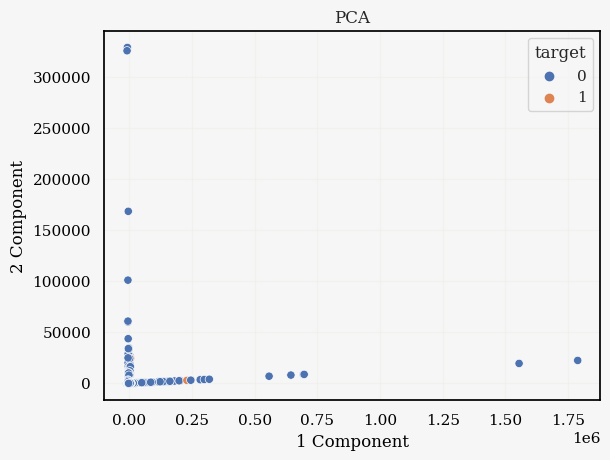

In [18]:
plt.title('PCA')
sns.scatterplot(data = pca_df,
                x = 0,
                y = 1,
                hue = 'target')
plt.xlabel('1 Component')
plt.ylabel('2 Component')

In [19]:
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from mlxtend.plotting import plot_decision_regions
from tqdm import tqdm
import warnings

In [20]:
warnings.filterwarnings(action = 'ignore')

In [21]:
X,y = pca_df.drop('target',axis = 1),pca_df['target']

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [22]:
rf = RandomForestClassifier(n_estimators = 300, random_state = 42)
xgb = XGBClassifier(n_estimators = 300, random_state = 42)
lgb = LGBMClassifier(n_estimators = 300, verbose = -1, random_state = 42)
mlp = MLPClassifier(activation = 'relu',learning_rate = 'adaptive')
logist = LogisticRegression(C = 1)
knn = KNeighborsClassifier()

models = [rf,xgb,lgb,mlp,logist,knn]

models_name = ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier',
                'MLPClassifier','LogisticRegression', 'KNeighborsClassifier']

In [33]:
def train_test_score(model, train_x,train_y,test_x,test_y):
    
    model.fit(train_x,train_y)
    train_pred = model.predict(train_x)
    
    test_pred = model.predict(test_x)
    test_proba = model.predict_proba(test_x)[:,1]
    
    train_score = round(accuracy_score(train_y, train_pred),2)
    test_score = round(accuracy_score(test_y, test_pred),2)
    auc_score = round(roc_auc_score(test_y,test_proba),2)
    return train_score,test_score,auc_score

6it [01:34, 15.81s/it]


Text(0.5, 0.98, 'Test Classifier rigion')

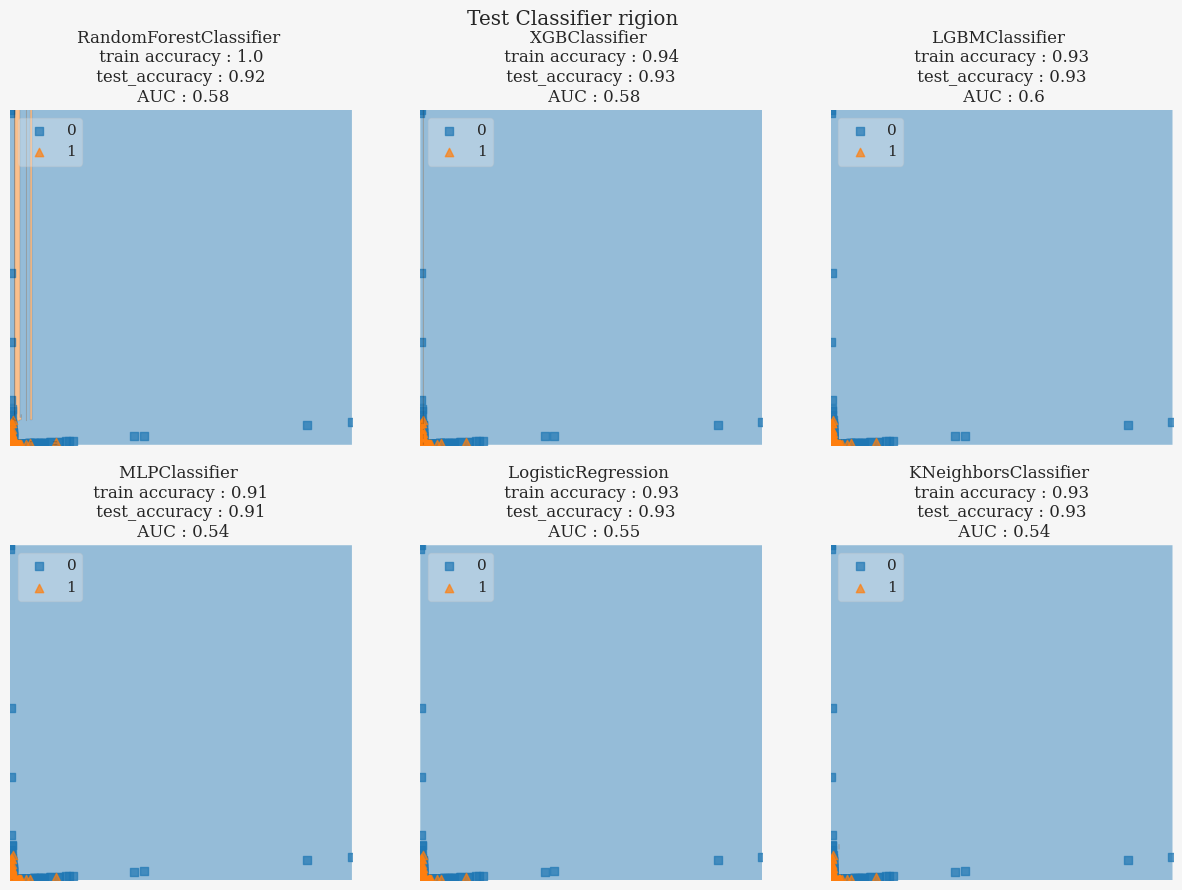

In [36]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
fig.subplots_adjust(hspace = 0.3)
ax = ax.flatten()


scatter_kwargs = {'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}


x_train,y_train = np.array(x_train),np.array(y_train)

for i,model in tqdm(enumerate(models)):
    
    train_score,test_score,Auc_score = train_test_score(model,x_train,y_train,x_test,y_test)
    
    plot_decision_regions(x_train,y_train,clf = model,
                            legend = 2,
                            scatter_kwargs = scatter_kwargs,
                            contour_kwargs = contourf_kwargs,
                            ax = ax[i])
    
    ax[i].set_title(f'{models_name[i]} \n train accuracy : {train_score} \n test_accuracy : {test_score} \n AUC : {Auc_score}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Test Classifier rigion')

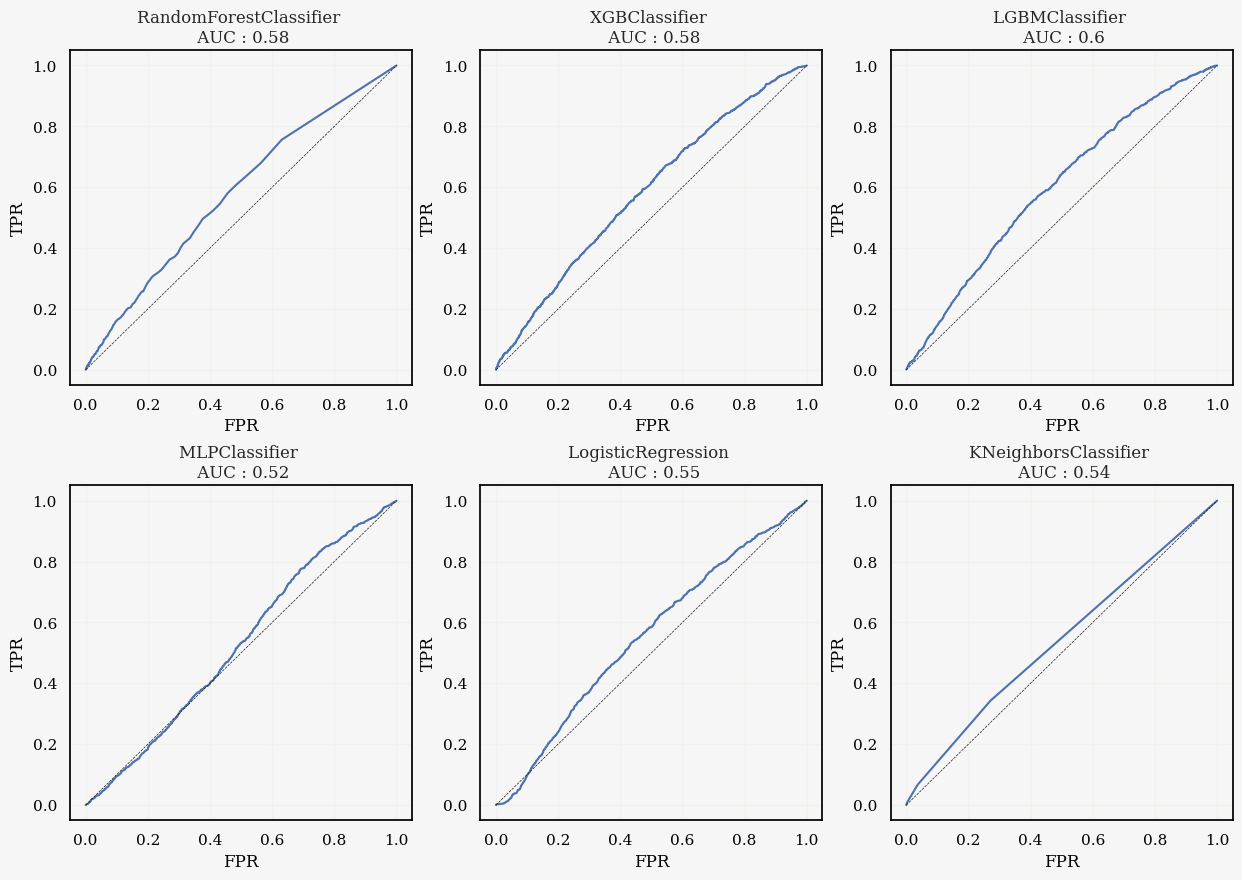

In [44]:
fig,ax = plt.subplots(ncols = 3, nrows = 2, figsize = (15,10))
fig.subplots_adjust(hspace = 0.3)
ax = ax.flatten()

for i,model in enumerate(models):
    
    model.fit(x_train,y_train)
    
    proba = model.predict_proba(x_test)[:,1]

    fpr,tpr,_ = roc_curve(y_test,proba)
    auc_score = round(roc_auc_score(y_test,proba),2)
    
    graph_df = pd.DataFrame({'FPR':fpr, 'TPR':tpr})
    
    sns.lineplot(data = graph_df,
                    x = 'FPR',
                    y = 'TPR',
                    ax = ax[i])
    ax[i].plot([0,1],[0,1], ls = '--', lw = 0.5, c = 'k')
    
    if i % 2 != 0:
        ax[i].set_ylabel('')
    ax[i].set_ylabel('TPR')
    ax[i].set_xlabel('FPR')
    ax[i].set_title(f'{models_name[i]} \n AUC : {auc_score}')

**I thinks PCA dosen't work :)**